# Splines in PyMC

:::{post} May 6, 2022 
:tags: patsy, pymc.Deterministic, pymc.Exponential, pymc.Model, pymc.Normal, regression, spline
:category: beginner
:author: Joshua Cook updated by Tyler James Burch, Chris Fonnesbeck
:::

## Introduction

Often, the model we want to fit is not a perfect line between some $x$ and $y$.
Instead, the parameters of the model are expected to vary over $x$.
There are multiple ways to handle this situation, one of which is to fit a *spline*.
The spline is effectively multiple individual lines, each fit to a different section of $x$, that are tied together at their boundaries, often called *knots*.

Below is a full working example of how to fit a spline using PyMC. The data and model are taken from [*Statistical Rethinking* 2e](https://xcelab.net/rm/statistical-rethinking/) by [Richard McElreath's](https://xcelab.net/rm/) {cite:p}`mcelreath2018statistical`.

For more information on this method of non-linear modeling, I suggesting beginning with [chapter 5 of Bayesian Modeling and Computation in Python](https://bayesiancomputationbook.com/markdown/chp_05.html) {cite:p}`martin2021bayesian`.

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from patsy import dmatrix

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927
az.style.use("arviz-darkgrid")

## Cherry blossom data

The data for this example is the number of days (`doy` for "days of year") that the cherry trees were in bloom in each year (`year`). 
For convenience, years missing a `doy` were dropped (which is a bad idea to deal with missing data in general!).

In [3]:
try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [4]:
blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)
blossom_data.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


After dropping rows with missing data, there are 827 years with the numbers of days in which the trees were in bloom.

In [5]:
blossom_data.shape

(827, 5)

If we visualize the data, it is clear that there a lot of annual variation, but some evidence for a non-linear trend in bloom days over time.

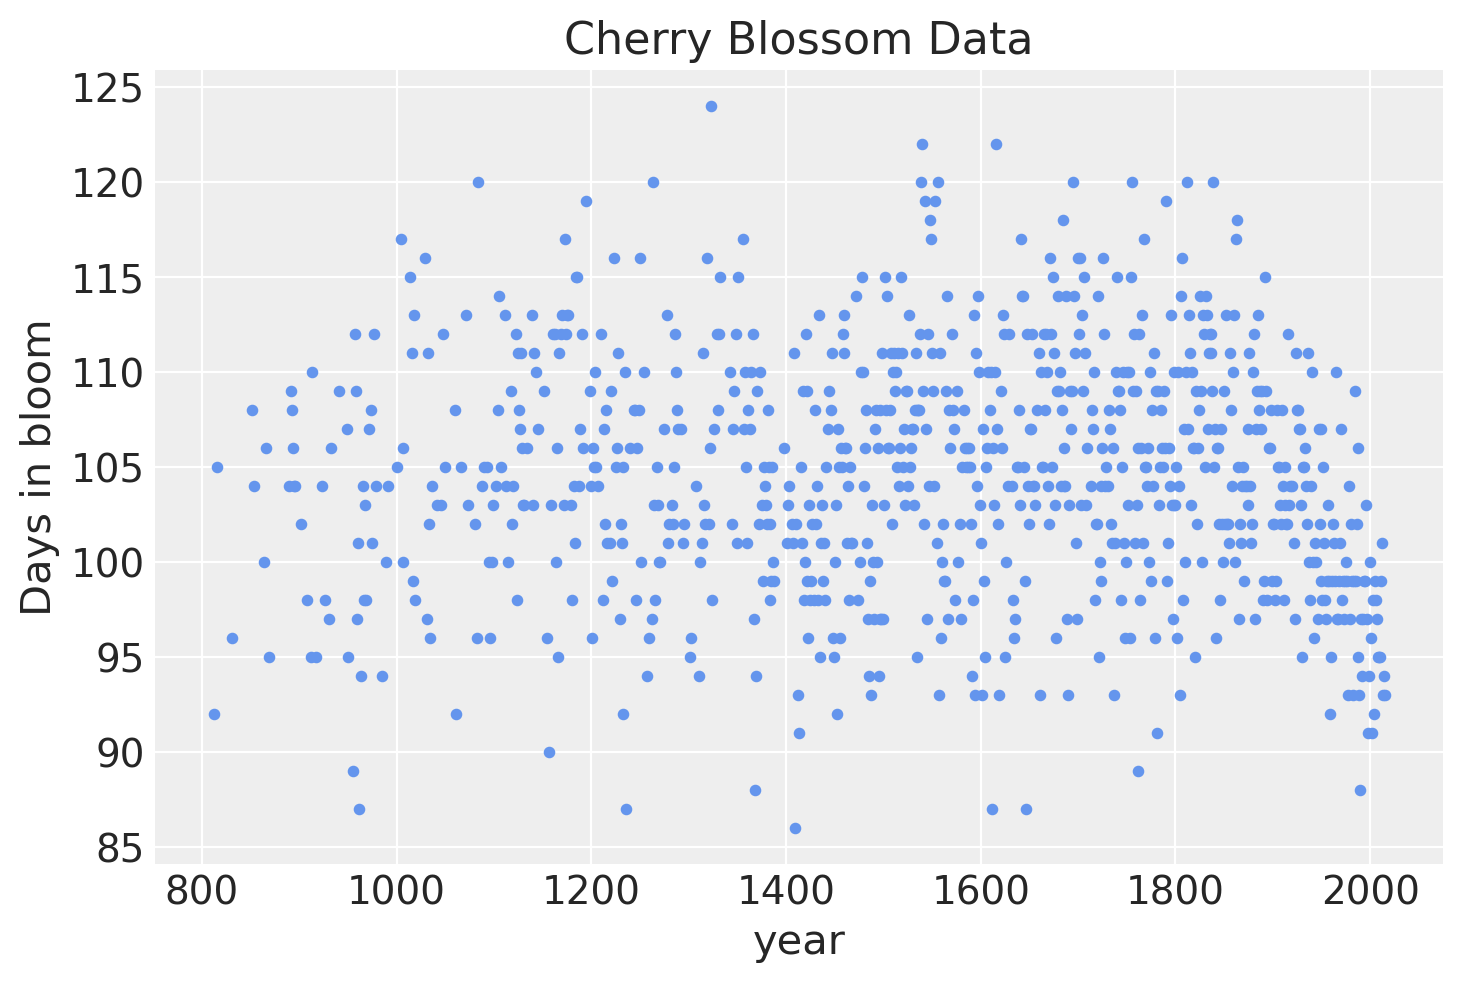

In [6]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Days in bloom"
);

## The model

We will fit the following model.

$D \sim \mathcal{N}(\mu, \sigma)$  
$\quad \mu = a + Bw$  
$\qquad a \sim \mathcal{N}(100, 10)$  
$\qquad w \sim \mathcal{N}(0, 10)$  
$\quad \sigma \sim \text{Exp}(1)$

The number of days of bloom $D$ will be modeled as a normal distribution with mean $\mu$ and standard deviation $\sigma$. In turn, the mean will be a linear model composed of a y-intercept $a$ and spline defined by the basis $B$ multiplied by the model parameter $w$ with a variable for each region of the basis. Both have relatively weak normal priors.

### Prepare the spline

The spline will have 15 *knots*, splitting the year into 16 sections (including the regions covering the years before and after those in which we have data). The knots are the boundaries of the spline, the name owing to how the individual lines will be tied together at these boundaries to make a continuous and smooth curve.  The knots will be unevenly spaced over the years such that each region will have the same proportion of data.

In [7]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

Below is a plot of the locations of the knots over the data.

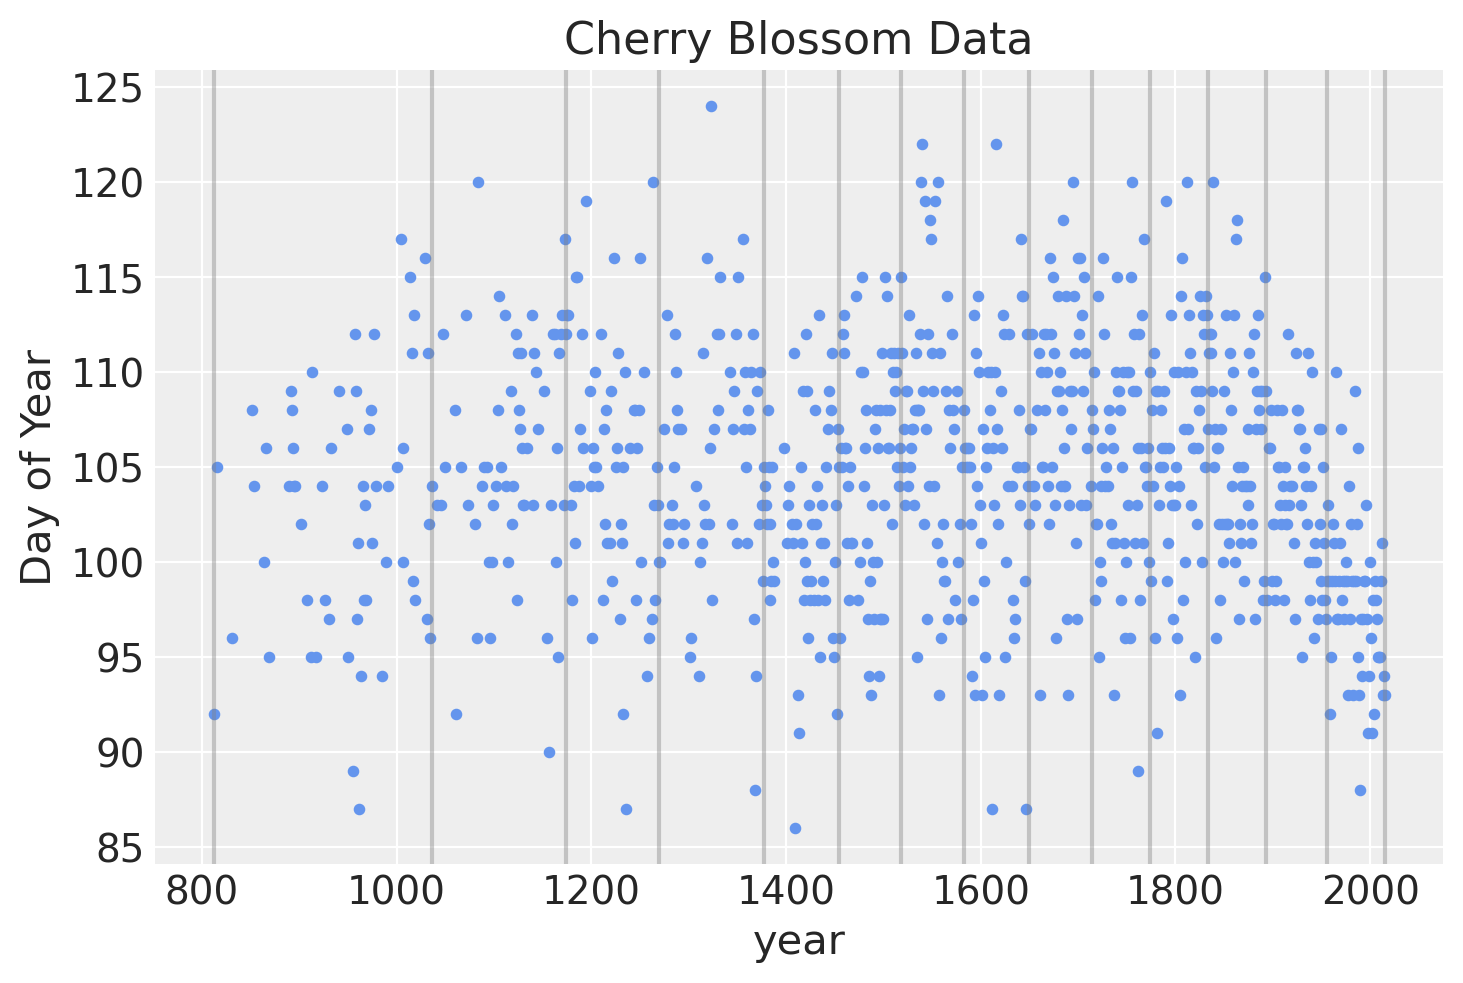

In [8]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

We can use `patsy` to create the matrix $B$ that will be the b-spline basis for the regression.
The degree is set to 3 to create a cubic b-spline.

In [9]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

The b-spline basis is plotted below, showing the *domain* of each piece of the spline. The height of each curve indicates how influential the corresponding model covariate (one per spline region) will be on model's inference of that region. The overlapping regions represent the knots, showing how the smooth transition from one region to the next is formed.

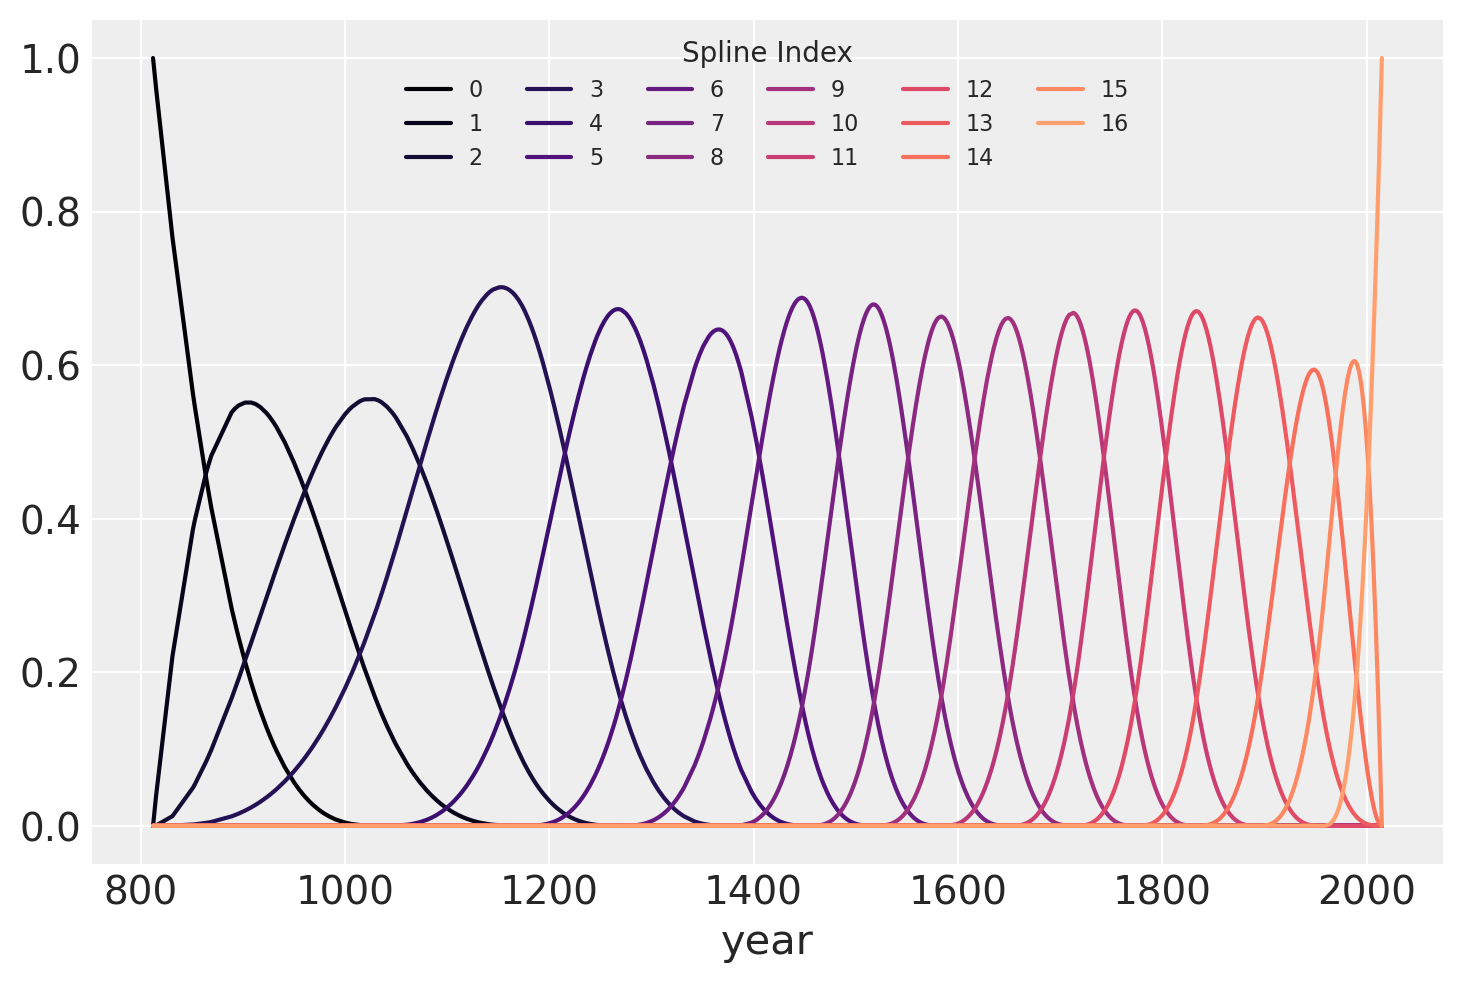

In [10]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

### Fit the model

Finally, the model can be built using PyMC. A graphical diagram shows the organization of the model parameters (note that this requires the installation of `python-graphviz`, which I recommend doing in a `conda` virtual environment).

In [11]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=blossom_data.doy, dims="obs")

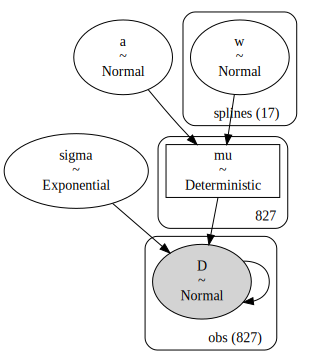

In [12]:
pm.model_to_graphviz(spline_model)

In [13]:
with spline_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.


## Analysis

Now we can analyze the draws from the posterior of the model.

### Parameter Estimates

Below is a table summarizing the posterior distributions of the model parameters.
The posteriors of $a$ and $\sigma$ are quite narrow while those for $w$ are wider.
This is likely because all of the data points are used to estimate $a$ and $\sigma$ whereas only a subset are used for each value of $w$.
(It could be interesting to model these hierarchically allowing for the sharing of information and adding regularization across the spline.) 
The effective sample size and $\widehat{R}$ values all look good, indicating that the model has converged and sampled well from the posterior distribution.

In [14]:
az.summary(idata, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,103.650,0.770,102.149,105.053,0.018,0.013,1742.0,2126.0,1.01
w[0],-1.844,2.193,-6.016,2.145,0.032,0.029,4734.0,3084.0,1.00
w[1],-1.636,2.071,-5.348,2.415,0.034,0.027,3754.0,2901.0,1.00
w[2],-0.292,1.916,-3.833,3.263,0.032,0.027,3568.0,3336.0,1.00
w[3],3.340,1.470,0.581,6.000,0.027,0.020,2877.0,2996.0,1.00
w[4],0.174,1.556,-2.601,3.206,0.030,0.023,2689.0,2671.0,1.00
w[5],2.069,1.619,-0.860,5.273,0.028,0.021,3246.0,2477.0,1.00
w[6],-3.533,1.477,-6.253,-0.684,0.028,0.020,2819.0,2878.0,1.00
w[7],5.492,1.495,2.741,8.316,0.027,0.019,2999.0,2985.0,1.00
w[8],-0.042,1.537,-2.982,2.881,0.029,0.022,2720.0,2828.0,1.00


The trace plots of the model parameters look good (homogeneous and no sign of trend), further indicating that the chains converged and mixed.

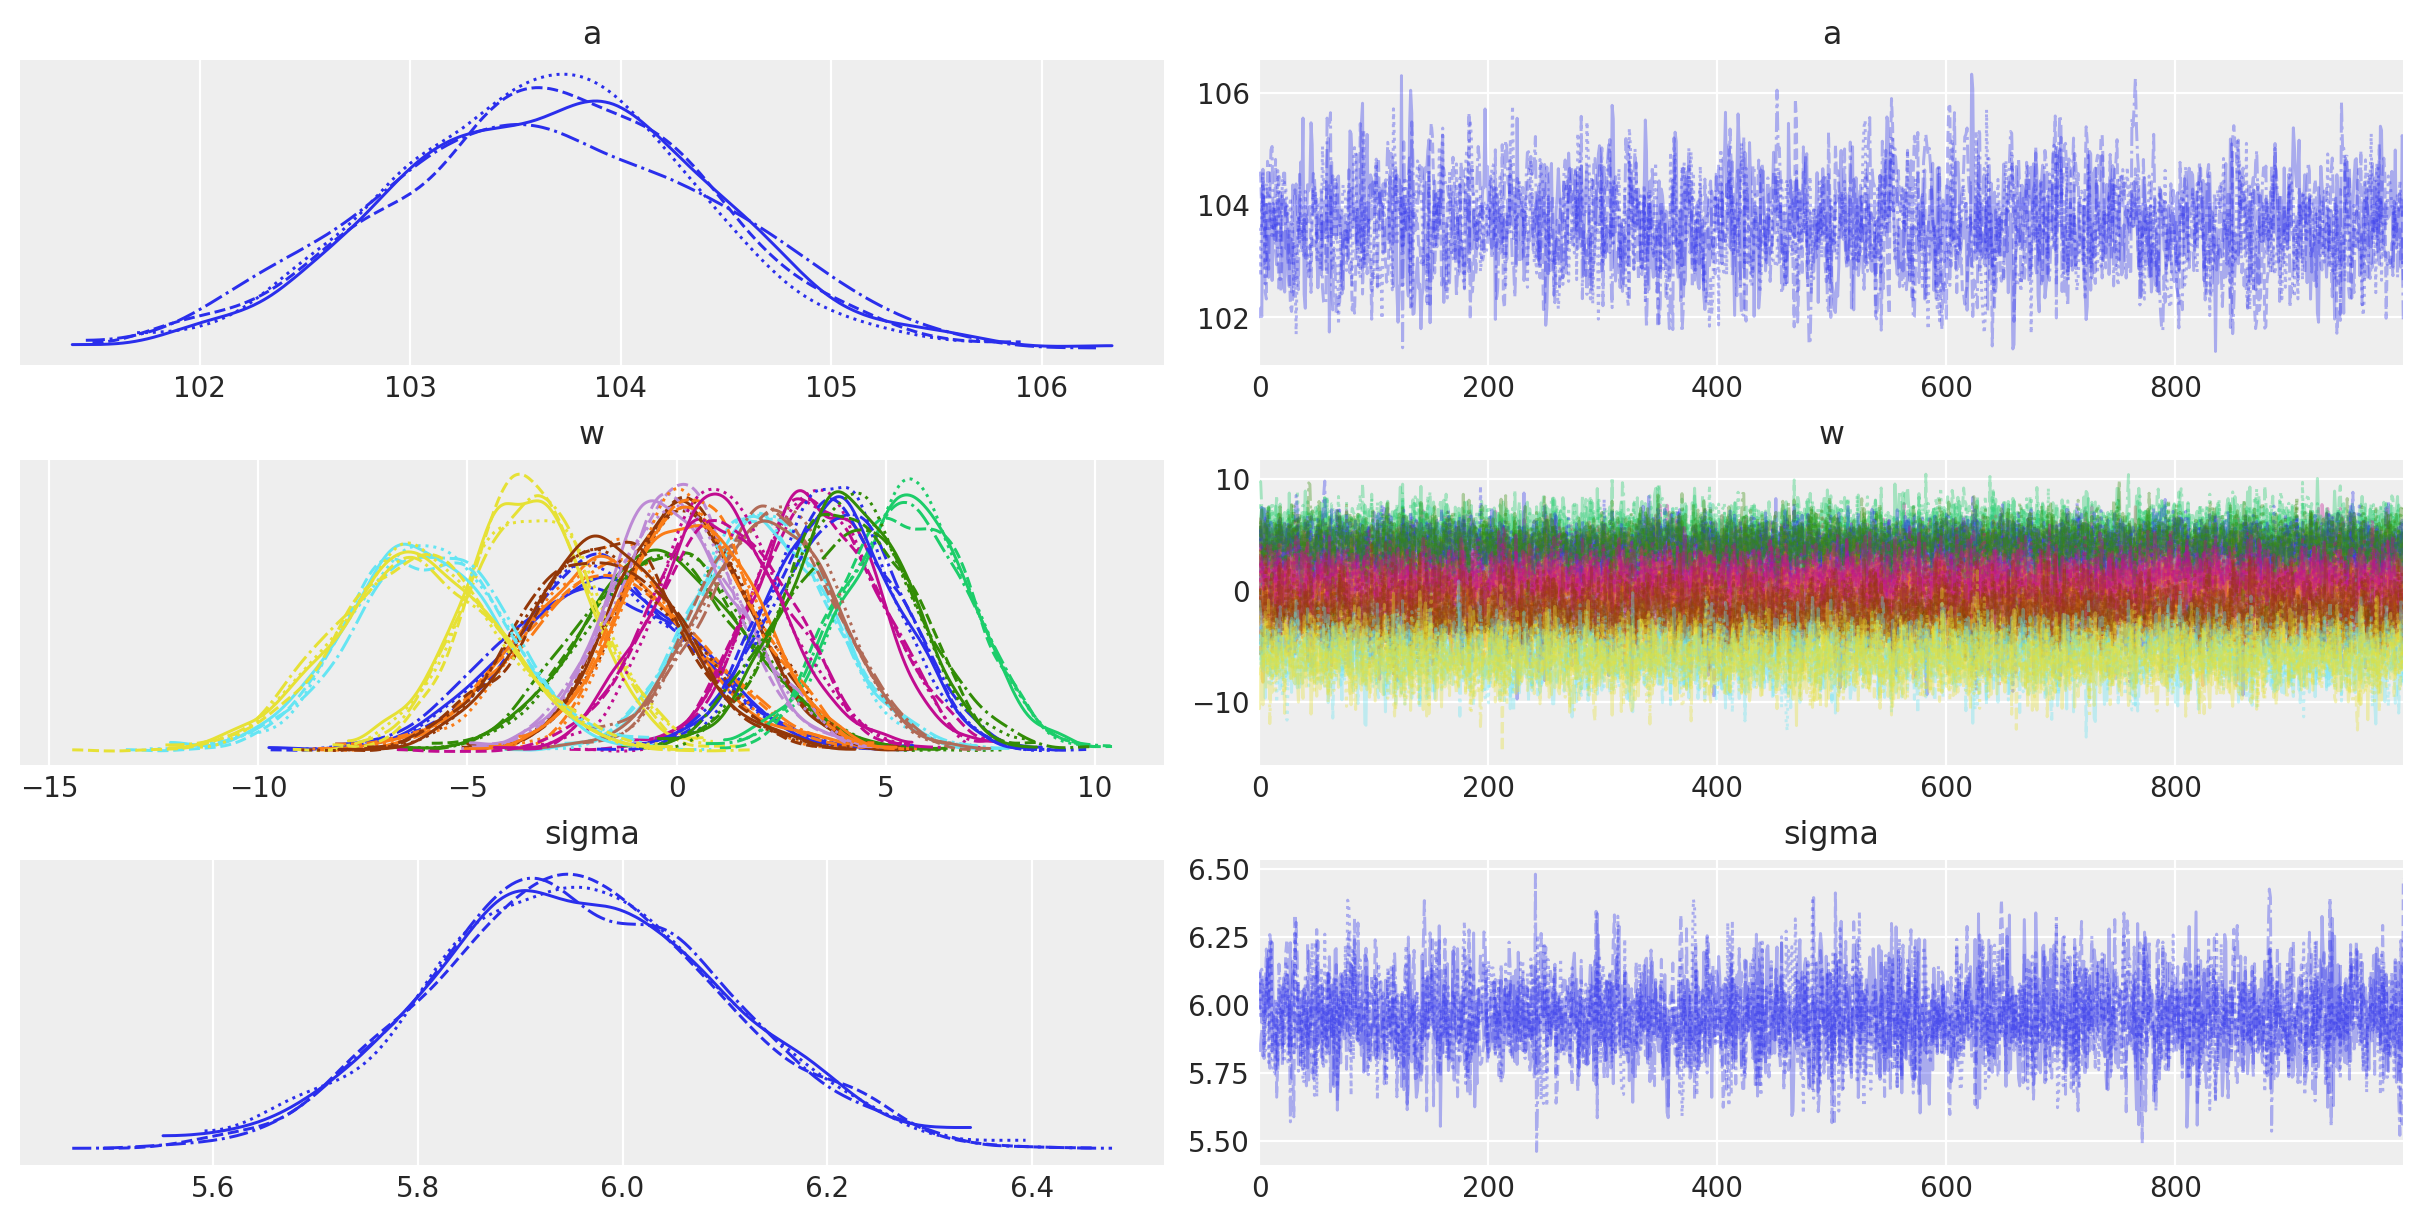

In [15]:
az.plot_trace(idata, var_names=["a", "w", "sigma"]);

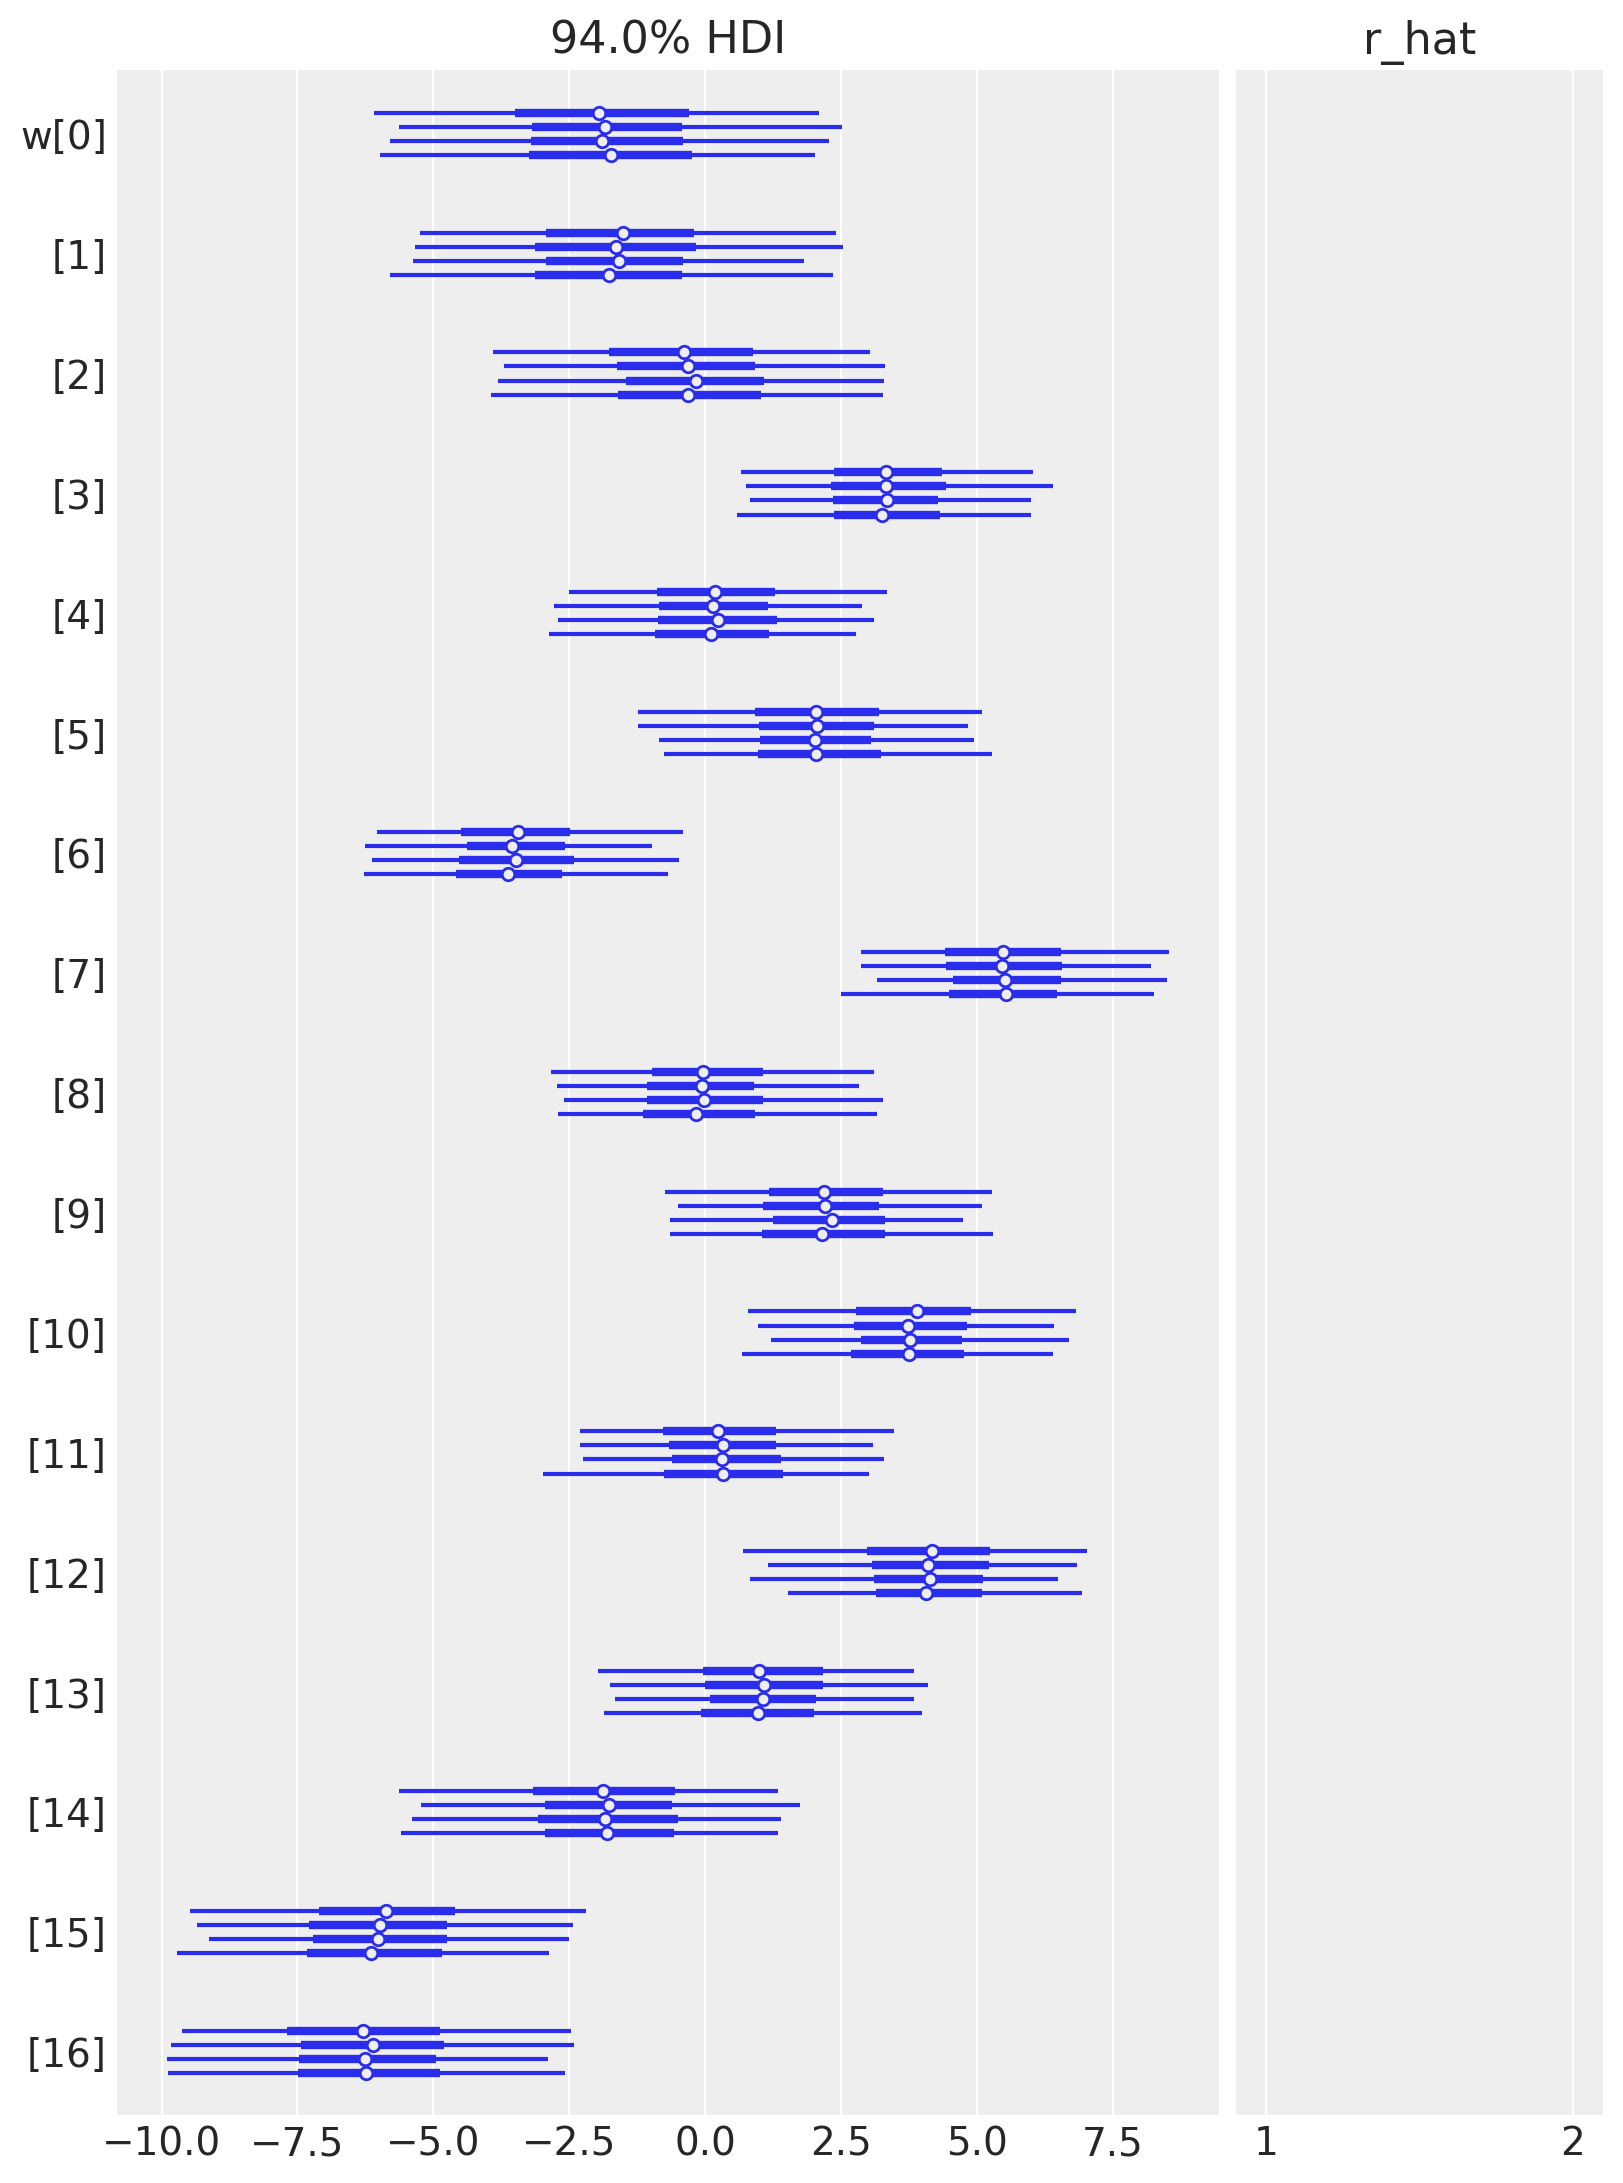

In [16]:
az.plot_forest(idata, var_names=["w"], combined=False, r_hat=True);

Another visualization of the fit spline values is to plot them multiplied against the basis matrix.
The knot boundaries are shown as vertical lines again, but now the spline basis is multiplied against the values of $w$ (represented as the rainbow-colored curves). The dot product of $B$ and $w$ – the actual computation in the linear model – is shown in black.

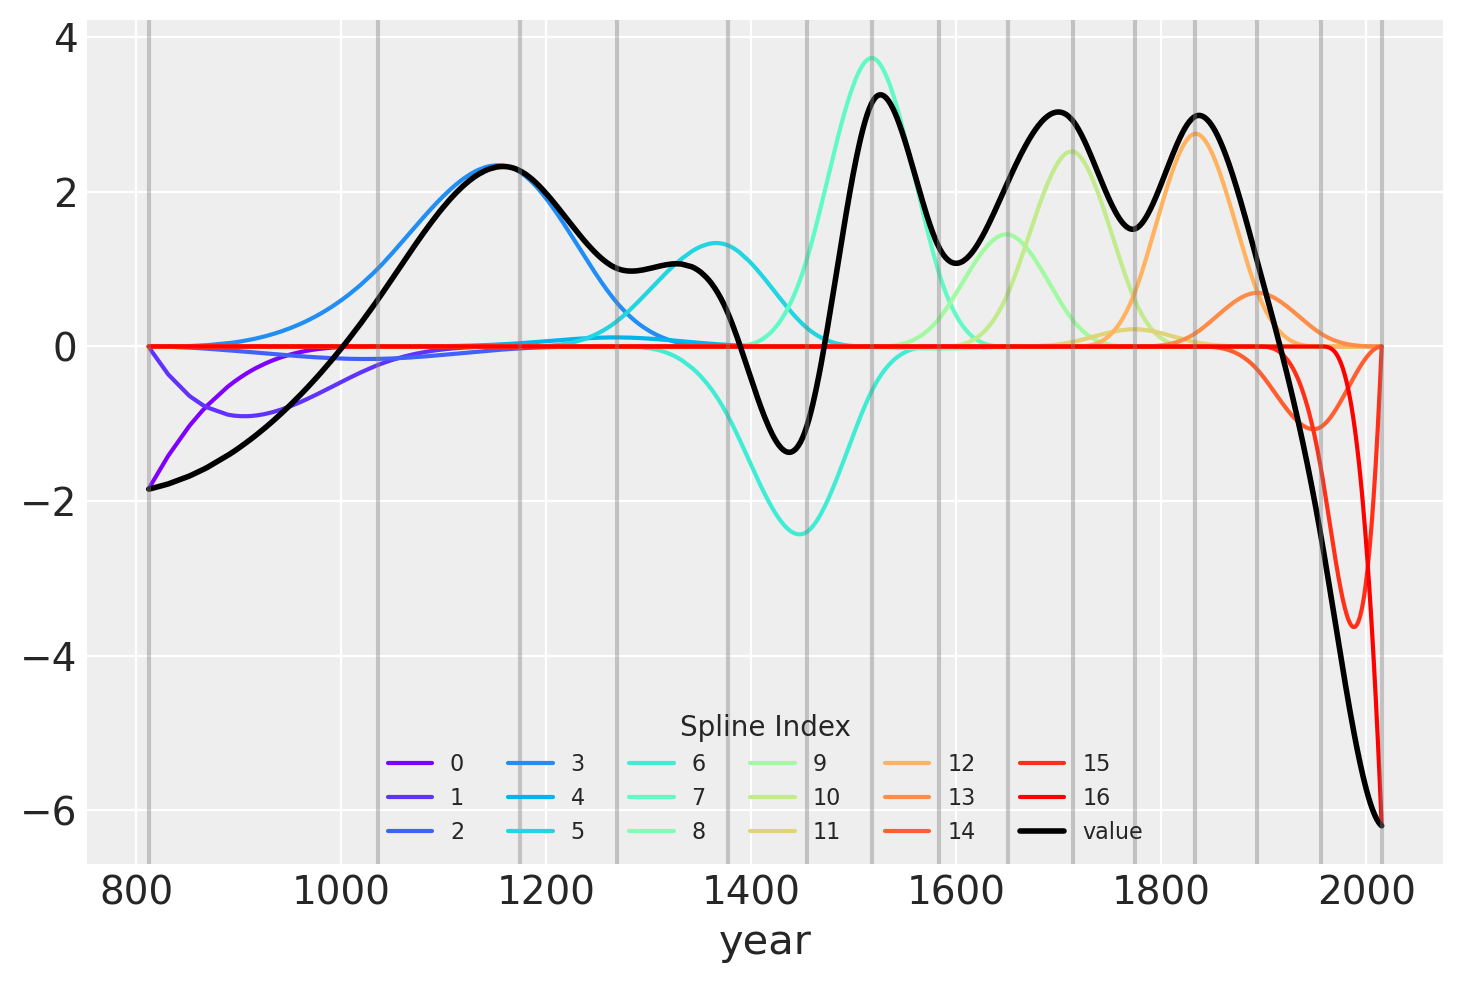

In [17]:
wp = idata.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("year", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

### Model predictions

Lastly, we can visualize the predictions of the model using the posterior predictive check.

In [18]:
post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
blossom_data_post = blossom_data.copy().reset_index(drop=True)
blossom_data_post["pred_mean"] = post_pred["mean"]
blossom_data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
blossom_data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

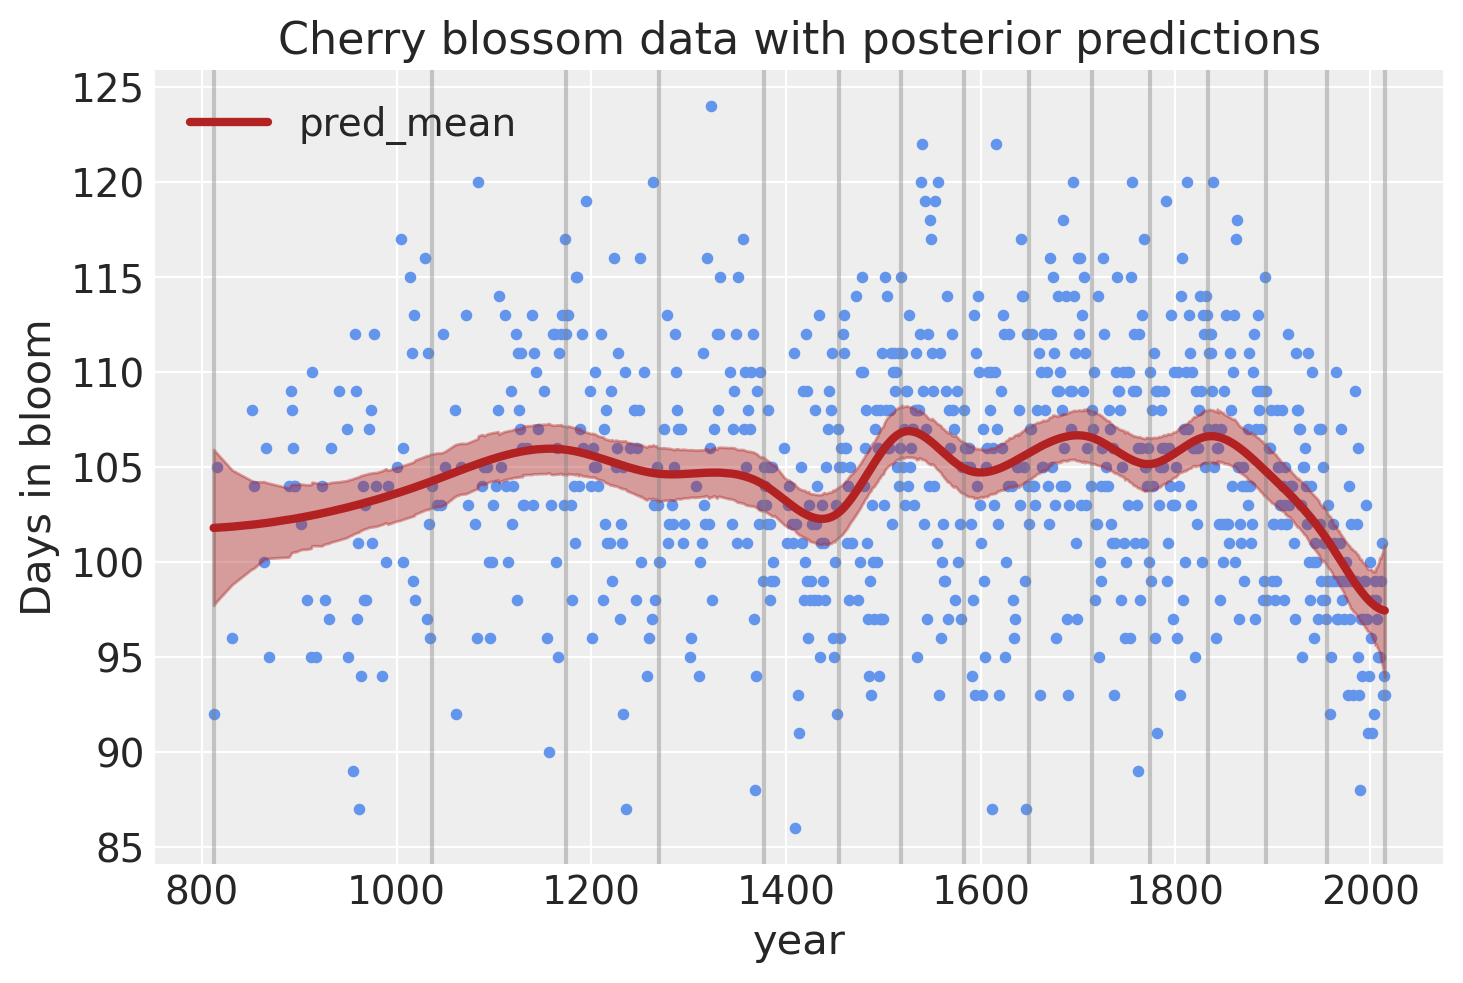

In [19]:
blossom_data.plot.scatter(
    "year",
    "doy",
    color="cornflowerblue",
    s=10,
    title="Cherry blossom data with posterior predictions",
    ylabel="Days in bloom",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

blossom_data_post.plot("year", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    blossom_data_post.year,
    blossom_data_post.pred_hdi_lower,
    blossom_data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,xarray,patsy

Last updated: Sat May 07 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

aesara: 2.6.2
xarray: 2022.3.0
patsy : 0.5.2

numpy     : 1.22.2
pandas    : 1.4.1
pymc      : 4.0.0b6
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) 
[GCC 9.4.0]
matplotlib: 3.5.1
arviz     : 0.12.0

Watermark: 2.3.0



:::{include} ../page_footer.md
:::